In [20]:
import pickle
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import sys
import re
import itertools
sys.path.insert(0, '/Users/lhao/Documents/Git/py_Halo-GEM/ecpy')
import seaborn as sns

In [21]:
sns.set_style('ticks')

In [2]:
from curate_kcat_light_goslim_asc_step02 import *

In [33]:
def load_post_and_ecoli(results02,results03):
    kcat_model02 = [item.loc for item in results02.posterior.values()] # those values are log10 transformed 1/h
    kcat_model02 = [10**item/3600 for item in  kcat_model02] # convert it to 1/s
    
    kcat_model03 = [item.loc for item in results03.posterior.values()] # those values are log10 transformed 1/h
    kcat_model03 = [10**item/3600 for item in  kcat_model03] # convert it to 1/s
    
    # load prior, do not use results.prior, as it was not the real prior. forgot to use .copy in the very begining
    model_one_pool_file = '../Results/template_ecModel_one_pool.pkl'
    tmp_ecmodel = pickle.load(open(model_one_pool_file,'rb'))
    df_enz_kcat = pd.read_csv('../Results/mapped_kcats_updated_with_ko.csv',index_col=0)

    priors = build_priors(tmp_ecmodel,df_enz_kcat)
    kcat_model_prior = [item.loc for item in priors.values()] # those values are log10 transformed 1/h
    kcat_model_prior = [10**item/3600 for item in  kcat_model_prior] # convert it to 1/s
    
    # load ecoli kcats
    kcatDB = pd.read_csv('../../../ComplementaryData/max_KCAT.txt',sep = '\t',header=None)
    ecoli_kcat = kcatDB[kcatDB[2].str.contains('escherichia coli')][3].values
    
    
    X02 = np.sort(kcat_model02)
    Y02 = np.array(range(len(X02)))/float(len(X02))
    
    X03 = np.sort(kcat_model03)
    Y03 = np.array(range(len(X03)))/float(len(X03))

    X_model_prior = np.sort(kcat_model_prior)
    Y_model_prior = np.array(range(len(X_model_prior)))/float(len(X_model_prior))

    X_ecoli = np.sort(ecoli_kcat)
    Y_ecoli = np.array(range(len(X_ecoli)))/float(len(X_ecoli))

    #X_bac = np.sort(bac_kcat)
    #Y_bac = np.array(range(len(X_bac)))/float(len(X_bac))

    #X_all = np.sort(kcatDB[3].values)
    #Y_all = np.array(range(len(X_all)))/float(len(X_all))

    return X02,Y02, X03, Y03, X_model_prior, Y_model_prior

In [62]:
def do_plot_compare_to_ecoli(X02,Y02, X03, Y03, X_model_prior, Y_model_prior):
    plt.figure(figsize=(4.2,2.8))
    
    plt.plot(X_model_prior  , Y_model_prior  ,label = '$Prior$ $H$. TD01')
    plt.plot(X02, Y02,label = '$Posterior$ (GoSlim)') #
    plt.plot(X03, Y03,label = '$Posterior$ (Individual)') #
    plt.plot(X_ecoli, Y_ecoli,label = '$E. coli$')

    #plt.plot(X_all  , Y_all  ,label = 'All')
    
    plt.xscale('log')
    plt.legend(loc=0,fontsize=8)
    plt.xlabel('$k_{cat}$ ($s^{-1}$)')
    plt.ylabel('Cumulative distribution')
    #plt.tight_layout()
    plt.savefig('../figures/prior_post_kcat_aculative_ecoli.pdf',bbox_inches='tight')
    plt.show()
    plt.close()

In [28]:
results02 = pickle.load(open('../Results/smc_abc_light_step_02.pkl','rb'))
results03 = pickle.load(open('../Results/smc_abc_light_step_03.pkl','rb'))

# Compare the mean kcat values. You can extract them directly from results.posterior. 
# or use results02.population.
#     data structure: [{((rxn_id,prot_id):kcat)}]*100. kcat is in the unit of 1/h
#     To calculate the mean in thel log10 space, firstly use np.mean(log10(x))


In [34]:
X02,Y02, X03, Y03, X_model_prior, Y_model_prior = load_post_and_ecoli(results02,results03)

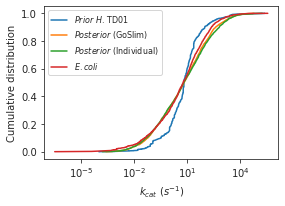

In [63]:
do_plot_compare_to_ecoli(X02,Y02, X03, Y03, X_model_prior, Y_model_prior)

In [6]:

#bac_kcat = kcatDB[kcatDB[2].str.contains('bacteria')][3].values

### GoSlim
The file is `../proteomics/go-slim-in model.xlsx`

In [8]:
# loda table and get 'Genes' column
go_slim_db = pd.read_excel('../proteomics/go-slim-in model.xlsx', index_col=None, header=0)
go_slim_db['Genes'] = [list(set(i[4:])- {np.nan}) for i in go_slim_db.values.tolist()]  # remove np.nan
go_slim_db = go_slim_db[['Description', 'GoTerm', 'GeneNumber', 'Classification','Genes']]
go_slim_db.head()

,Description,GoTerm,GeneNumber,Classification,Genes
0,transmembrane transport,GO:0055085,67,metabolism,"[TD01GL001428, TD01GL001550, TD01GL001765, TD0..."
1,amino acid transport,GO:0006865,40,metabolism,"[TD01GL003009, TD01GL000868, TD01GL002889, TD0..."
2,carbohydrate metabolic process,GO:0005975,110,metabolism,"[TD01GL000224, TD01GL002488, TD01GL001868, TD0..."
3,carbohydrate transport,GO:0008643,15,metabolism,"[TD01GL002091, TD01GL001071, TD01GL003296, TD0..."
4,cellular amino acid metabolic process,GO:0006520,222,metabolism,"[TD01GL001003, TD01GL001059, TD01GL000022, TD0..."


In [9]:
# get 'Kcats' column for 'Genes' column
Gens_id_list = np.array([re.sub('(prot_)|(_(c|p|e))','',key[1]) for key in results02.posterior.keys()])
kcat_model = np.array(kcat_model)
kcat_model_prior = np.array(kcat_model_prior)

kcats_column = []
kcats_prior_column = []
for index in go_slim_db.index:
    genes_row = go_slim_db.iloc[index]['Genes']
    kcats_row = []
    kcats_prior_row = []
    for gene_i in genes_row:
        kcats_i = kcat_model[Gens_id_list == gene_i ]
        kcats_row.append(list(kcats_i))
        kcats_prior_i = kcat_model_prior[Gens_id_list == gene_i ]
        kcats_prior_row.append(list(kcats_prior_i))
    kcats_column.append(kcats_row)
    kcats_prior_column.append(kcats_prior_row)
go_slim_db['Kcats'] = kcats_column
go_slim_db['Kcats_prior'] = kcats_prior_column
go_slim_db.head()

,Description,GoTerm,GeneNumber,Classification,Genes,Kcats,Kcats_prior
0,transmembrane transport,GO:0055085,67,metabolism,"[TD01GL001428, TD01GL001550, TD01GL001765, TD0...","[[413.2200242735417], [0.2082176798211871], []...","[[5.922046751932458], [6.456527653644495], [],..."
1,amino acid transport,GO:0006865,40,metabolism,"[TD01GL003009, TD01GL000868, TD01GL002889, TD0...","[[], [], [1.2442013573599617], [20.46038769914...","[[], [], [6.456527653644495], [5.9220467519324..."
2,carbohydrate metabolic process,GO:0005975,110,metabolism,"[TD01GL000224, TD01GL002488, TD01GL001868, TD0...","[[18.903510406834826], [334.11768510670777, 0....","[[256.7085271205102], [34.195935709707356, 34...."
3,carbohydrate transport,GO:0008643,15,metabolism,"[TD01GL002091, TD01GL001071, TD01GL003296, TD0...","[[], [], [11.215577848506875], [], [12.4928481...","[[], [], [6.456527653644495], [], [25.36730178..."
4,cellular amino acid metabolic process,GO:0006520,222,metabolism,"[TD01GL001003, TD01GL001059, TD01GL000022, TD0...","[[4.802286526628859, 0.3347167328233229], [229...","[[10.977616958143553, 10.977616958143553], [47..."


In [10]:
# TODO: some gens have no kcat such as TD01GL001757
kcats_i = kcat_model[Gens_id_list == 'TD01GL001757' ]
print(kcats_i)

[]


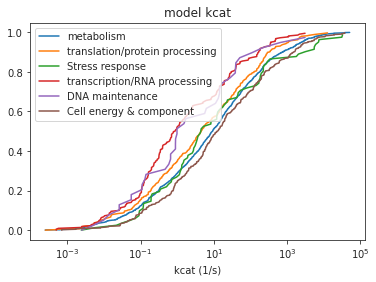

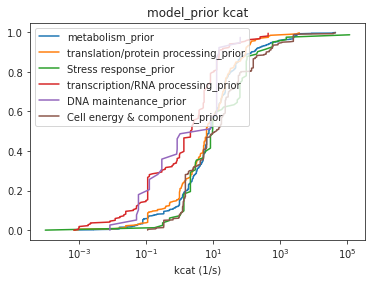

In [22]:
# plot for each classification
go_slim_db['Kcats_all'] = go_slim_db['Kcats'].apply(itertools.chain.from_iterable)  # convert to One-dimensional list
go_slim_db['Kcats_all'] = go_slim_db['Kcats_all'].apply(list)

go_slim_db['Kcats_prior_all'] = go_slim_db['Kcats_prior'].apply(itertools.chain.from_iterable)
go_slim_db['Kcats_prior_all'] = go_slim_db['Kcats_prior_all'].apply(list)

classifications = set(go_slim_db['Classification'])
for classification_i in classifications:
    kcat_i = go_slim_db[go_slim_db['Classification']==classification_i]['Kcats_all'].values
    kcat_i = list(itertools.chain.from_iterable(kcat_i))
    X_i = np.sort(kcat_i)
    Y_i= np.array(range(len(kcat_i)))/float(len(kcat_i))
    plt.plot(X_i  , Y_i  ,label = classification_i)
plt.xscale('log')
plt.legend(loc=0)
plt.xlabel('kcat (1/s)')
plt.title('model kcat')
plt.show()
plt.close()

# %%
# plot prior
for classification_i in classifications:
    kcat_prior_i = go_slim_db[go_slim_db['Classification']==classification_i]['Kcats_prior_all'].values
    kcat_prior_i = list(itertools.chain.from_iterable(kcat_prior_i))
    X_prior_i = np.sort(kcat_prior_i)
    Y_prior_i= np.array(range(len(kcat_prior_i)))/float(len(kcat_prior_i))
    plt.plot(X_prior_i  , Y_prior_i  ,label = classification_i + '_prior')
plt.xscale('log')
plt.legend(loc=0)
plt.xlabel('kcat (1/s)')
plt.title('model_prior kcat')
plt.show()
plt.close()



72 cellular respiration
98 ion transport
29 ion transmembrane transport
152 nucleic acid metabolic process
34 transcription, DNA-dependent
0 ribosome assembly
224 alpha-amino acid biosynthetic process
39 translation
0 response to osmotic stress
16 ATP biosynthetic process
208 oxidation-reduction process
45 tricarboxylic acid cycle


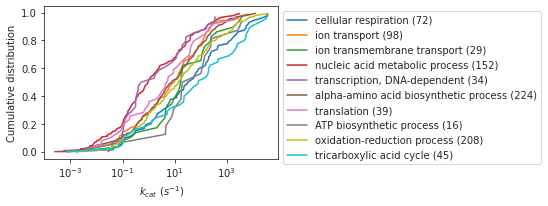

In [64]:
descriptions = ['cellular respiration','ion transport','ion transmembrane transport',
                'nucleic acid metabolic process','transcription, DNA-dependent','ribosome assembly',
               'alpha-amino acid biosynthetic process','translation','response to osmotic stress',
               'ATP biosynthetic process','oxidation-reduction process','tricarboxylic acid cycle']

plt.figure(figsize=(4.2,2.8))
for description_i in descriptions:
    kcat_i = go_slim_db[go_slim_db['Description']==description_i]['Kcats_all'].values
    kcat_i = list(itertools.chain.from_iterable(kcat_i))
    print(len(kcat_i),description_i)
    if len(kcat_i) == 0: continue
    X_i = np.sort(kcat_i)
    Y_i= np.array(range(len(kcat_i)))/float(len(kcat_i))
    plt.plot(X_i  , Y_i  ,label = description_i + ' ({0})'.format(len(kcat_i)))
plt.xscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('$k_{cat}$ ($s^{-1}$)')
plt.ylabel('Cumulative distribution')
plt.savefig('../figures/post_kcat_aculative_go_terms.pdf',bbox_inches='tight')
plt.show()
plt.close()



In [46]:
plt.savefig?